# Topic 3 - Potential flow

This notebook is a potential flow calculator that you can use to put in differnet flow elements, move them around, visualise flow and pressure coefficients. This will enable you to get a feel for how to do superposition of different flow elements to create a variety of new flows!

We will be using $z$ as the vertical direction and $x$ as the streamwise direction. For a right-hand rule, this means that positive $y$ axis is into the plane of the paper. This means the vertical velocity is $w$ and the streamwise velocity is $u$.


In the cells below, we initialise the domain and then define 4 most important flow elements.

#### 1) Uniform flow
#### 2) Source/Sink
#### 3) Doublet
#### 4) Vortex

All other potential flows are just a combination of these 4 elements. Once you have combined the flow elements, then you can get a new streamfunction.

The streamline itself is represented by the streamfunction.  Note that the streamline is always tangetial to the velocity field. Therfore, the slope of the streamline at any given point $(x,z)$ is represented by the $\frac{dz}{dx}$.

### For a streamline: $\frac{dz}{dx} = \frac{w}{u}$

where $w$ and $u$ are the velocity components along $z$ and $x$ direction.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

#For masking the data
import numpy.ma as ma

#Interpolation method
from scipy.interpolate import RectBivariateSpline as interp_2D

#For root-finding
from scipy.optimize import fsolve

## Initialise the domain

In the code below, we intialise the domain size for out potential flow. We are given a max and min value for the domain size in two directions. We are also defining the spacing between subsequent points in the domain. Then, we are create an array for $x$ and $z$ with the corresponding spacing. Finally, we are creating a mesh with the meshgrid command that gives you a 2D grid that we are going to use for all calculations and plotting.

$Domain_x_min$ is the min range of the x axis. $Domain_x_max$ = 4 is the max range of the x axis. $Domain_z_min$ is the min range of the z axis. $Domain_z_max$ is the max range of the z axis.

$dx$ and  $dz$ sets the spacing between successive points in the domain along the $x$ and $z$ axes. Note that you can change the spacing as you wish. For Numerical methods, this spacing is really important! Finer spacing leads to more accurate results but takes longer for computation.

We will create a function to make this domain and later on before we start solving problems, we will always have to call this function to initialise the grid on which you want to solve it.


In [2]:
def create_grid(Domain_x_min,Domain_x_max,Domain_z_min,Domain_z_max,dx,dz):
  """This function creates a 2D grid between xmin and xmax as well zmin and zmax with spacing dx and dz. The function also returns a vector (1D array) x and z coordinates"""

  #This command makes 1-D array (or vectors) for x and z axis
  #If you ever want to know just the x-coordinates or the z-coordinate then jus t use xa and za or that
  xa= np.arange(Domain_x_min,Domain_x_max+dx,dx)
  za= np.arange(Domain_z_min,Domain_z_max+dx,dz)

  #This command makes a mesh (2-D array) using xa and za, This is now our domain
  x,z = np.meshgrid(xa,za)
  return[xa,za,x,z]
  #All our flow solutions will be computed in this grid

## COMPUTING VELOCITIES and PRESSURE

In this notebook, we will only be using cartesian coordinate system. Therefore, all velocities are computed in the cartesian coordinate system. Eventhough some streamfunctions are derived in polar coordinates in the lectures, we convert everything to cartesian coordinates to help with the coding. However, analytically, given a function in polar coordinates, you should be able to differentiate and get the velocities.

In cartesian coordinate system:

### $u = \frac{\partial \psi}{\partial z}$ and $w = -\frac{\partial \psi}{\partial x}$


In polar coordinate system:

### $V_r = \frac{1}{r}\frac{\partial \psi}{\partial \theta}$ and $V_\theta = -\frac{\partial \psi}{\partial r}$

Note that you can also convert from cartesian to polar using simple trignometric relations:
$u = V_r cos\theta - V_\theta sin\theta$ and $w = V_r sin\theta + V_\theta cos\theta$

In some cases, it is tedious to do this conversion.

In this notebook, we are going to use numpy to calculate the gradients numerically instead of analytically. This is because, we can then just compute the values of streamfunction on a cartesian grid and numerically differentiate that along the different directions to get the gradients and therefore velocities.

The function np.gradient function returns a array with the first row has the gradient along the $z$ direction and the second row has the gradient along the $x$ direction. Note that the way the gradient return the value is flipped. So, you get the gradient along $z$ first and then along $x$.  We can then just assign the corresponding row to get the $u$ and the $w$ component as done below.

Further information on  np.gradient is available here https://numpy.org/doc/stable/reference/generated/numpy.gradient.html

In [3]:
 #The input for this function is the streamfunction
def findvelocities(psi):
  """This command computes the w and u components of velocity as gradient(psi). The gradient along the columns is taken in first and then the rows. The function gradient computes the first derivative of a variable along a given axis."""
  u,w = np.gradient(psi)

  u = u/dz
  w = -1*w/dx

  return [u,w]

Once you have the velocities, you can use the Bernoulli's equation and get the pressure at a given point:

### $p = p_\infty + \frac{1}{2}\rho U^2_\infty - \frac{1}{2}\rho(u^2 + w^2)= p_\infty + \frac{1}{2}\rho U^2_\infty - \frac{1}{2}\rho(V^2_r + V^2_\theta)$

#### This above equation can be re-written to get the pressure coefficient $C_p = \frac{p-p_\infty}{\frac{1}{2}\rho U^2_\infty}$

### From this, we get $C_p = 1 - \frac{u^2+w^2}{U_\infty} = 1 - \frac{u^2_r+u^2_\theta}{U_\infty}$

In some flows, there may not be a freestream velocity. In that case, we use a Reference velocity (which should be known to compute the pressure gradient). In the function below, we are using this reference velocity to compute pressure coefficient. If you have a freestream velocity, then, $U_{ref} = U_\infty$

This pressure coefficient will be available at every point in the grid. That means, we can get the value of pressure and velocity at everypoint in the grid.

In [4]:
def findpressure(u,w,Uref):
  """This command computes the pressure coefficient from the velocities and a reference speed"""
  Cp = 1-((u**2+w**2)/Uref**2)
  return Cp

## MASKING DATA

Sometimes because of the way we compute the gradients, the data becomes very large and affects our display of contours and vectors. Therefore, it is best to mask the data that we think are erroneous due to numerical artefacts. This is done in using $numpy$ function called $ma.masked\_where$. It works pretty much the same way as $np.where$. The function finds the indices that meet the conditions and blanks out the values in those indices in the array given next to it. This masked array is then passed. Once done, the cells that meets the blanking condition are not shown in any plots.  

Below, I have created a function called $mask\_box$ that takes the coordinates of the 4 corners and masks all the points within these coordinates for $\psi$, $u$ and $w$. If you compute the pressure once the mask is applied then that would be masked as well.

In [5]:
def mask_box(xms,xmf,zms,zmf,psi,u,w):
  """This function takes the four corners of a rectangular box and masks the data within the box"""
  psi_m = ma.masked_where((x>xms)&(x<=xmf)&(z>zms)&(z<=zmf),psi)
  u_m = ma.masked_where((x>xms)&(x<=xmf)&(z>zms)&(z<=zmf),u)
  w_m = ma.masked_where((x>xms)&(x<=xmf)&(z>zms)&(z<=zmf),w)
  return[psi_m,u_m,w_m]

An alternate way to mask the data is to make it conditional on the value of a cell itself. Typically, we can do this using the value of a given variable. Below, I have created a function called $mask\_data$ where the cells that meet a certain condtion in $\psi$ are masked.  If you compute the pressure once the mask is applied then that would be masked as well.

In [6]:
def mask_data(val,val_min,val_max,psi,u,w):
  """This function masks data between a min and max value for a given parameter. We use 1 = psi, 2 = u and 3 = w"""
  if (val==0):
    valf = psi
  if (val==1):
    valf = u
  if (val==2):
    valf = w

  psi_m = ma.masked_where((valf>val_min)&(valf<val_max),psi)
  u_m = ma.masked_where((valf>val_min)&(valf<val_max),u)
  w_m = ma.masked_where((valf>val_min)&(valf<val_max),w)
  return[psi_m,u_m,w_m]

## FINDING INDICES OF SPECIFIC POINTS

You should note that $x,z,\psi, u, w$ and $C_p$ are all 2D-arrays. That means each grid point is addressed with two indices (one for the rows and one of the columns). Typically, x changes along the columns and remains a constant along rows and $z$ changes along rows and remain the same along columns. To access information for a specific grid point ($x_i,z_i$), we need to find the index along the row (for $z_i$) and the index along the column (for $x_i$) and the use those indices in $u, w, \psi$ and $C_p$. So, what we will now do is write a function that will provide the nearest index along a vector (that has either the x coordinates or the z coordinates - this is held in $xa$ and $za$ arrays in the $create\_grid$ function) to a specific location. Then, in subsequent cells, you can use this to find the index that meets your needs.

For more information: https://www.geeksforgeeks.org/find-the-nearest-value-and-the-index-of-numpy-array/


In [7]:
def find_index(axis_vec,loc):
  """This function finds the nearest index in a vector that meets your condition"""
  #This finds x-index for the location
  difference_array = np.absolute(axis_vec-loc)
  # find the index of minimum element from the array
  index = difference_array.argmin()
  return index

## Interpolating at a point

You can interpolate the data from a 2D array in to a single point to get a value at that point. For this, we need to use the $interpolate$ package from the $Scipy$ library. We are specifically using $RectBivariateSpine$ type interpolation. This uses splines to interpolate values in different cells. There is specific way to call this function and it is done here below.

The inputs to this function as $x$ and $z$ coordinates (that is available to you in 1D array $xa$ and $za$) as well as the 2D array of the variable that you want to interpolate. You also need the provide the coordinate ($xl,zl$) at which you want the interpolated value. The function will return the value that you need.

In [8]:
def interpolate_values(xa,za,func,xl,zl):
  """This function takes the 1D array (or vector) of x and z coordinates as well as the 2D array of data that you want to interpolate. It porvide the value of the function at xl and zl points specified by you."""
  fun =  interp_2D(za, xa, func) #You dont need to use 2D array of x and y for this.
  #Just the 1D array with coordinates of y and x are needed.
  #You also need to pass y coordinates first and then the x coordinates
  interp_value = fun(zl,xl)[0] #This interpolates the values of the function f in the new set of points.
  #Note that you need to pass y coodinate first and then the x-coordinate
  return interp_value

##PLOTTING VECTORS AND CONTOURS
We will be plotting vectors and contours of the flowfield to see a 2D representation of the flowfield created using potential flow. There are few things to remember when plotting this.

We can plot the vector map of the flowfield using the command $quiver$. This is done as $plt.quiver(x,z,u,w,scale=value)$.The scale will change the size of the vectors.Here, $value$ is an integer that gives you the size of the arrows in the vector plot. Usually, the arrows are self-scaled based on the largest vector.

All quantities $u,w, psi$ and $C_p$ are 2D quantities and can be plotted as a contour plot. The command typically used to plot these contours is, $plt.contour(x,z,variable,levels)$. Here, the $variable$ can be the whatever you want to see the variation in $x$ and $z$ directions (so, $u, w, \psi$ and $C_p$).

There are two ways to change levels. \\
1. You can set the number of level to an integer. This gives take the total range from minimum value to maximum value of your variable and divide it in to equal number of levels given by the integer. For example, \\
$plt.contour(x,z,u,50)$ will plot contours lines of $u$ at 50 levels. \\

2. You can also specify a range of levels. This is done by creating a numpy array that has the specific levels that you want to show. You can create, $levels = np.arange(min,max,intervals)$ and use this when plotting. For example, $plt.contour(x,z,u,levels)$ where $levels = np.arange(0,1,0.1)$ will plot contour levels from 0 to 1 in intervals of 0.1. \\

Finally, you can also get filled contours by using the command $plt.contourf$. All other arguments for this is identical to $plt.contour$. Below, we will use these commands to plot the different things we want.  

# BUILDING BLOCKS (or LEGO Bricks)

# Uniform flow
This function create the streamfunction for uniform flow.

U is the horizontal speed and W is the vertical speed.

If you have magnitude $U_\infty$ and angle $\alpha$ then U = $U_\infty cos(\alpha)$ and W = $U_\infty sin(\alpha)$.

Note that $\alpha$ is just $tan^{-1}(W/U)$

### The stream function in cartesian coordinates is given by: $\psi = Uz - Wx$

### The stream function in polar coordinates is given by: $\psi = Ursin\theta - Wrcos\theta$

For polar coordinates: The positive radial direction is still pointing outwards from the centre and the positive tangential direction is in the counter-clockwise direction.

In [9]:
def uniform_flow(Uinf,alpha):
  """This command is the stream function for Uniform flow. The input are Uinf and angle alpha (alpha is in degrees)"""
  psiu = Uinf*np.cos(np.pi*alpha/180)*z - Uinf*np.sin(np.pi*alpha/180)*x

  return psiu

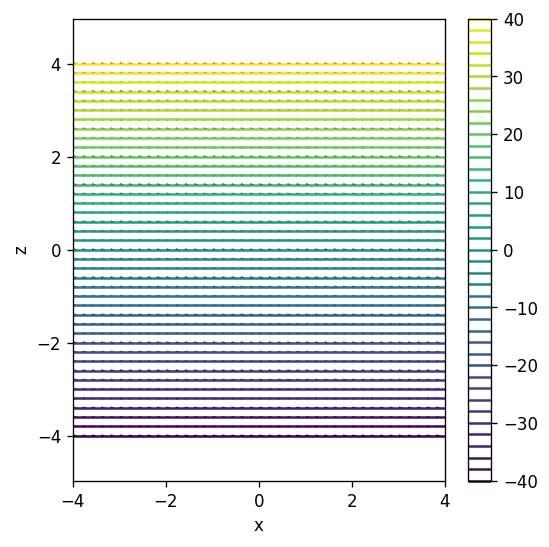

In [10]:
#This is a dummy run to just show uniform flow
Domain_x_min = -4
Domain_x_max = 4
Domain_z_min = -4
Domain_z_max = 4
dx = dz = 0.2

#We first create grid to compute the flow
[xa,za,x,z] = create_grid(Domain_x_min,Domain_x_max,Domain_z_min,Domain_z_max,dx,dz)

Uinf = 10
alpha = 0

psi = uniform_flow(Uinf,alpha)
[u,w] = findvelocities(psi)

plt.figure(figsize=(5,5),dpi=120)# make the plot
plt.contour(x,z,psi,50)       # streamlines
#Note that you can change the number of contours

plt.colorbar()
plt.quiver(x,z,u,w)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')
plt.show()

# Source or Sink

The function in the cell below will create the streamfunction for a point source or a sink.
A source or a sink has a strength $Q$ (where Q> 0 is a source and Q<0 is a sink).

The streamfunction for a source/sink is given by:

## $\psi(r,\theta) = \frac{Q \theta}{2\pi}$

The angle $\theta$ is the angle made by any given point in the grid with the location of the source. In a cartesian grid, this source or sink can be located at a point ($x_0,z_0$). If $x_0$ = 0 and $z_0$ = 0, then the source/sink is at the origin. You can move the location of the source and sink by changing the value of $x_0$ and $z_0.

The radial location of a point $(x,z)$ away from the source/sink located at $(x_0,z_0)$ is given by,

## $r = \sqrt{(x-x_0)^2 + (z-z_0)^2}$ and the angle of that point $\theta$ = $tan^{-1}(\frac{z-z_0}{x-x_0})$

The $\theta$ in the streamfunction is the same theta that identified the point $(x,z)$. So, if you have a value of the point $(x,z)$ and know the location of source/sink $(x_0,z_0)$,then you can find the streamfunction (and hence the streamlines) that represent the flow in cartesian coordinates

To convert the streamfunction given above in to cartesian coordinates, you just need to enter the values for $\theta$ and $r$ in terms of $x$ and $z$.

## $\psi(x,z) = \frac{Q}{2\pi}tan^{-1}(\frac{z-z_0}{x-x_0})$


Do move the point $(x_0,z_0)$ and see what happens!!

You can also add multiple sources and sinks in to the flow and see what happens. For example, you can create the flow past an oval by putting one source and one sink separated by some distance.


In [11]:
def source(Q,x0,z0):
 """The input to this function is the strength and the location (x0,z0) of source/sink. Positive Q is source and negative Q is sink."""
 #This command finds the radial coordinate r from the cartesian coordinate
 #relative to this specific flow element

 r = np.sqrt((x-x0)**2+(z-z0)**2)

 #This command finds the tangential angle theta from the cartesian coordinate
 #relative to this specific flow element

 theta = np.arctan2(z-z0,x-x0)

 #This command is the stream function for source/sink
 psis = Q*theta/(2*np.pi)

 return psis

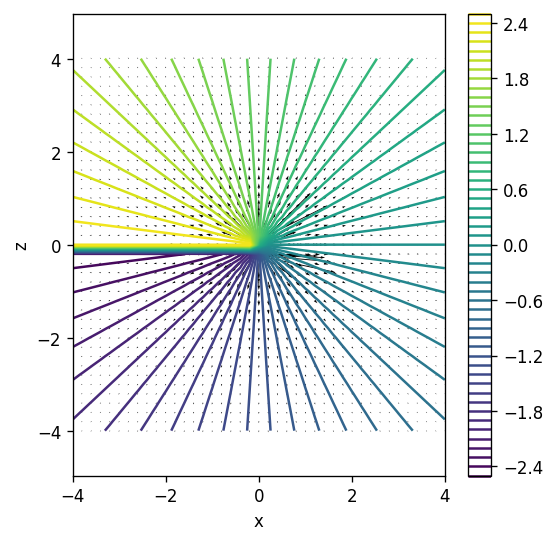

In [29]:
#This is a run cell to just show source/sink

#This is a dummy run to just show uniform flow
Domain_x_min = -4
Domain_x_max = 4
Domain_z_min = -4
Domain_z_max = 4
dx = dz = 0.2

#We first create grid to compute the flow
[xa,za,x,z] = create_grid(Domain_x_min,Domain_x_max,Domain_z_min,Domain_z_max,dx,dz)

psi = source(5,0,0)

[u,w] = findvelocities(psi)

#psi,u,w = mask_box(-4,4,-dz,dz,psi,u,w)


plt.figure(figsize=(5,5),dpi=120)       # make the plot
plt.contour(x,z,psi,50)                  # streamlines
plt.colorbar()
plt.quiver(x,z,u,w)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')
plt.show()

## Doublet

A double is basic flow element that combines the presence of a source and sink that are separated by infinitisimally small distance. The source and sink have equal strength ($Q$ and $-Q$). They are separated by a distance $l$. The doublet is defined as a flow element where the product of $Q$ and $l$ tends to a finite value when $l$ tends to zero. Therefore, we can define $\kappa$ = $Ql$.

The function in the cell below will create the streamfunction for a Doublet.
A Doublet has a strength $\kappa$.

The streamfunction for a Doublet is given by:

## $\psi(r,\theta) = -\frac{\kappa}{2\pi}\frac{sin\theta}{r}$

The angle $\theta$ is the angle made by any given point in the grid with the location of the doublet. In a cartesian grid, this doublet can be located at any point ($x_0,z_0$). If $x_0$ = 0 and $z_0$ = 0, then the doublet is at the origin. You can move the location of the doublet by changing the value of $x_0$ and $z_0$.

The radial location of a point $(x,z)$ away from the doublet located at $(x_0,z_0)$ is given by,

## $r = \sqrt{(x-x_0)^2 + (z-z_0)^2}$ and the angle of that point $\theta$ = $tan^{-1}(\frac{z-z_0}{x-x_0})$

The $\theta$ in the streamfunction is the same theta that identified the point $(x,y)$. To convert the streamfunction given above in to cartesian coordinates, you just need to enter the values for $sin\theta$ and $r$ in terms of $x$ and $z$.

### Note that $sin\theta = \frac{z-z_0}{\sqrt{(x-x_0)^2 + (z-z_0)^2}}$

## $\psi(x,z) = -\frac{\kappa}{2\pi}\frac{z-z_0}{(x-x_0)^2 + (z-z_0)^2}$

The sign of $\kappa$ determines the alignment of source and sink. If the source is to the left of the sink, then, $\kappa$ is positive. This will ensure that the flow goes away from the doublet on the left and come towards the doublet on the right. If the source is to the right of the sink, then, $\kappa$ will be negative. This will ensure that the flow goes away from the doublet on the right and come towards the doublet on the left.

Do move the point ($x_0,z_0$) and see what happens!!

In [13]:
def doublet(Kappa,x0,z0):
  """The input to this function is the strength and the location (x0,z0) of the doublet. Positive doublet is source on the left and sink on the right. Negative doublet is sink on the left and source on ther right."""
  #This command finds the radial coordinate r from the cartesian coordinate
  #relative to this specific flow element
  r = np.sqrt((x-x0)**2+(z-z0)**2)

  #This command finds the tangential angle theta from the cartesian coordinate
  #relative to this specific flow element
  theta = np.arctan2(z-z0,x-x0)

  #This command is the stream function for source/sink
  psid = -Kappa*(z-z0)/(2*np.pi*r*r)

  return psid

(-4.0, 4.0)

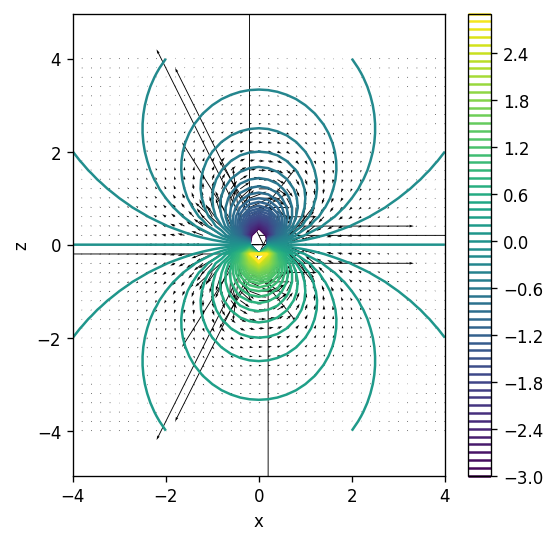

In [30]:
#Here we demonstrate a doublet

Domain_x_min = -4
Domain_x_max = 4
Domain_z_min = -4
Domain_z_max = 4
dx = dz = 0.2

#We first create grid to compute the flow
[xa,za,x,z] = create_grid(Domain_x_min,Domain_x_max,Domain_z_min,Domain_z_max,dx,dz)

#Doublet strength is given by kappa
kappa = 2*np.pi

psi = doublet(kappa,0,0)

[u,w] = findvelocities(psi)

#psi,u,w = mask_box(-2*dx,2*dx,-2*dz,2*dz,psi,u,w)

Cp = findpressure(u,w,Uinf)


#We are computing the body here based on theory...

plt.figure(figsize=(5,5),dpi=120)       # make the plot
plt.contour(x,z,psi,np.arange(-3,3,.1))      # streamlines
plt.colorbar()
plt.quiver(x,z,u,w,scale=20)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim([-4, 4])
plt.ylim([-4, 4])

# Vortex

The function in the cell below will create the streamfunction for a point vortex.
A vortex has a strength $\Gamma$ = $\int \vec{V}\cdot\vec{ds}$

The main thing for you to remember is that $\Gamma$ is positive in the clockwise direction (even through positive $\theta$ direction is counterclockwise). For the cartesian coordinate system we are using, positive $y$ axis is in to the plane of the paper and $\Gamma$ has to be positive in the clockwise direction to satisfy the right-hand rule.

The streamfunction for a vortex is given by:

## $\psi = \frac{\Gamma}{2\pi} ln(r)$

### Really important to note that positive value of $\Gamma$ means that the vortex is spinning in the clockwise direction.

The angle $\theta$ is the angle made by any given point in the grid with the location of the vortex. In a cartesian grid, this vortex can be located at a point ($x_0,z_0$). If $x_0$ = 0 and $z_0$ = 0, then the vortex is at the origin. You can move the location of the vortex by changing the value of $x_0$ and $z_0$.

The radial location of a point $(x,z)$ away from the vortex located at $(x_0,z_0)$ is given by,

## $r = \sqrt{(x-x_0)^2 + (z-z_0)^2}$ and the angle of that point $\theta$ = $tan^{-1}(\frac{z-z_0}{x-x_0})$

The $r$ in the streamfunction is the same $r$ that identified the point $(x,y)$ relative to $(x_0,z_0)$. So, if you have a value of the point $(x,z)$ and know the location of vortex $(x_0,z_0)$, then you can find the streamfunction (and hence the streamlines) that represent the flow.

Do move the point ($x_0,z_0$) and see what happens!!

In [15]:
def vortex(Gamma,x0,z0):
  """The input to this function is the circulation and the location (x0,z0) of the vortex. Positive Gamma is rotation in clockwise direction. Negative Gamma is rotation in counter-clockwise direction."""

  #This command finds the radial coordinate r from the cartesian coordinate
  #relative to this specific flow element
  r = np.sqrt((x-x0)**2+(z-z0)**2)

  #This command finds the tangential angle theta from the cartesian coordinate
  #relative to this specific flow element
  theta = np.arctan2(z-z0,x-x0)

  #This command is the stream function for a vortex
  psiv = Gamma*np.log(r)/(2*np.pi)

  return psiv

(-4.0, 4.0)

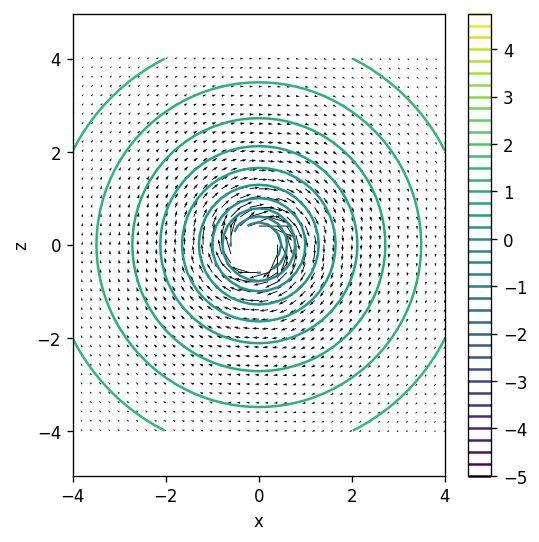

In [31]:
#This is a dummy run to just show uniform flow
Domain_x_min = -4
Domain_x_max = 4
Domain_z_min = -4
Domain_z_max = 4
dx = dz = 0.2

#We first create grid to compute the flow
[xa,za,x,z] = create_grid(Domain_x_min,Domain_x_max,Domain_z_min,Domain_z_max,dx,dz)


#Here we demonstrate a vortex
Gamma = 2*np.pi

psi = vortex(Gamma,0,0)

[u,w] = findvelocities(psi)


psi,u,w = mask_box(-2*dx,2*dx,-2*dz,2*dz,psi,u,w)

Cp = findpressure(u,w,Uinf)

#We are computing the body here based on theory...

plt.figure(figsize=(5,5),dpi=120)       # make the plot
plt.contour(x,z,psi,np.arange(-5,5,0.25))
plt.colorbar()
plt.quiver(x,z,u,w,scale=30)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim([-4, 4])
plt.ylim([-4, 4])

# Superposition and Representing different shapes using streamlines

We are going to create new flows by superposition of the basic flow elements. To do this, we just need to add the streamfunctions of the different flow elements to create a new streamfunction. Once, you have this streamfunction, you can plot streamlines, compute velocities and pressures.

### $\psi = \psi_1 + \psi_2 + \psi_3 +...$

For example, $\psi_1$ can be a uniform flow and $\psi_2$ can be a source. This gives you a rankine half body!
We will expand on this below.

It should be noted here that any streamline in the flow can be considered as a solid surface. This is because there is no flow normal to the streamline. This would be identical to a solid surface in an inviscid flow where you cannot have flow cross a solid surface. Therefore, to represent a given geometry, all we need to do is identify a specific streamline that best represents the geometry we want to see. Then, we can call the streamline that looks like the geometry as the object. Then, we can get flow pattern (streamlines) and the velocities past a give body if we looked around that specific streamline.

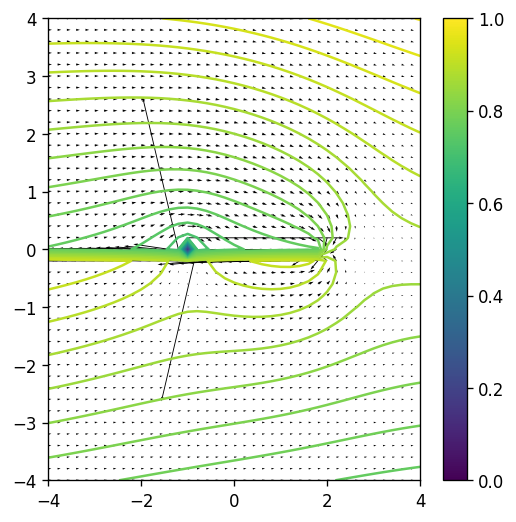

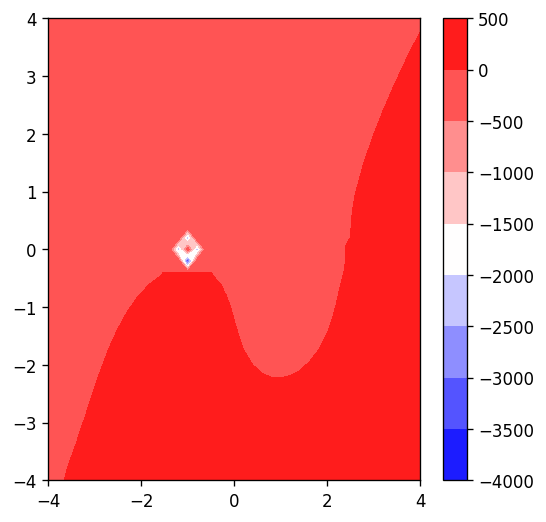

In [17]:
#YOUR CODE HERE TO PLAY AROUND WITH THE VARIOUS FLOW ELEMENTS!!!
Domain_x_min = -4
Domain_x_max = 4
Domain_z_min = -4
Domain_z_max = 4
dx = dz = 0.2

#We first create grid to compute the flow
[xa,za,x,z] = create_grid(Domain_x_min,Domain_x_max,Domain_z_min,Domain_z_max,dx,dz)

#HERE I AM DOING A UNIFORM FLOW + VORTEX + SOURCE
Uinf = 5
alpha = 0
Q = -8*np.pi
Gamma = 6*np.pi

psi = uniform_flow(Uinf,alpha) + vortex(Gamma,-1,0)+ source(Q,2,0)

[u,w] = findvelocities(psi)

Cp = findpressure(u,w,Uinf)

plt.figure(figsize=(5,5),dpi=120)
plt.contour(x,z,psi,50)
plt.quiver(x,z,u,w)
plt.colorbar()


plt.figure(figsize=(5,5),dpi=120)
plt.contourf(x,z,Cp,cmap='bwr')
plt.colorbar()

## Example 1 - Rankine body flow

The first example for superposition is a Rankine half body.  Here, $\psi_1$ is a uniform flow and $\psi_2$ is a source. This gives you a rankine half body! You can change the strength of source relative to uniform flow to generate the size of the body. In fact, it can be shown that that the full height of the body $2h = \frac{Q}{U_\infty}$

### $\psi_{rankine} = \psi_{uniform flow} + \psi_{source}$

It is important to remember to use the formulae either all in cartesian coordinates or all in cylindrical coordinates. Do not mix and match!


(-4.0, 4.0)

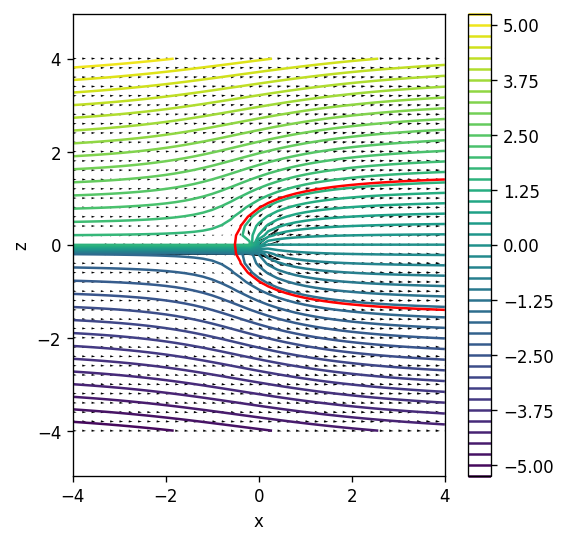

In [33]:
#This cell block will give us the flow past rankine half body.

Domain_x_min = -4
Domain_x_max = 4
Domain_z_min = -4
Domain_z_max =4
dx = dz = 0.2

#We first create grid to compute the flow
[xa,za,x,z] = create_grid(Domain_x_min,Domain_x_max,Domain_z_min,Domain_z_max,dx,dz)

#Change the values of Uinf and Q to get different bodies.
Uinf = 1
alpha = 0
Q = np.pi

psi = uniform_flow(Uinf,alpha)+ source(Q,0,0)

[u,w] = findvelocities(psi)

#psi,u,w = mask_box(-4,4,-dz,dz,psi,u,w)

#psi,u,w = mask_data(0,-0.4*Q,0.4*Q,psi,u,w)

Cp = findpressure(u,w,Uinf)

plt.figure(figsize=(5,5),dpi=120)       # make the plot
plt.contour(x,z,psi,50)      # streamlines
plt.colorbar()
plt.quiver(x,z,u,w)
plt.contour(x,z,abs(psi),levels = [0.5*Q],colors='r')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim([-4, 4])
plt.ylim([-4, 4])

total height of hill:  [3.141]


(-4.0, 4.0)

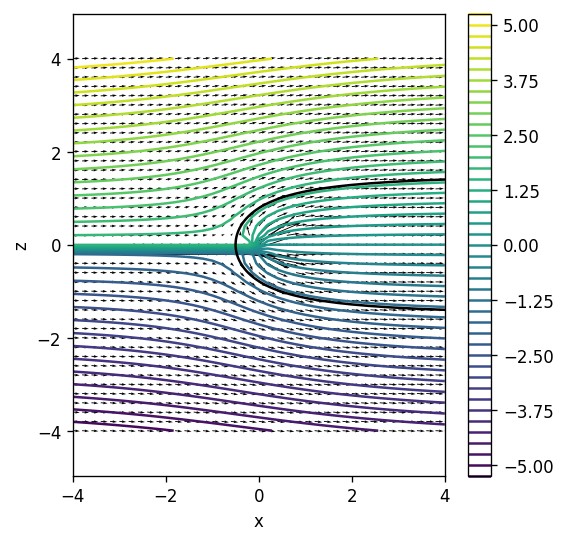

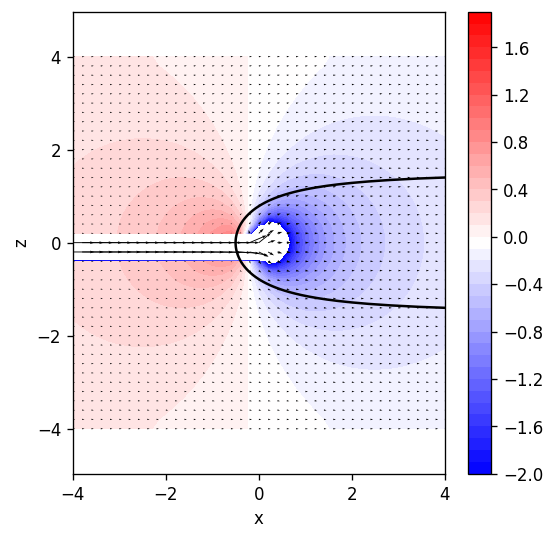

In [34]:
#We are computing the body here based on theory...
theta = np.linspace(0.001,2*np.pi-0.001,100)
r = 0.5*Q*(1-theta/np.pi)/(Uinf*np.sin(theta))

xb = r*np.cos(theta)
zb = r*np.sin(theta)

#This plots the streamlines and vectors again
plt.figure(figsize=(5,5),dpi=120)       # make the plot
plt.contour(x,z,psi,50)      # streamlines
plt.colorbar()
plt.quiver(x,z,u,w,scale=50)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim([-4, 4])
plt.ylim([-4, 4])

#This plots the body based on the calculation...
plt.plot(xb,zb,'k-')

#Find the value of "2h" by computing "z" coordinate value at theta = 0.
#We cannot evaluate it at 0 but at a value very close to it.
idx = np.where(theta==0.001)
tot_h = 2*zb[idx[0]]
print("total height of hill: ",np.round(tot_h,3))

#Plotting the pressure coefficient as contours
plt.figure(figsize=(5,5),dpi=120)
plt.contourf(x,z,Cp,np.arange(-2,2,0.1),cmap='bwr')
plt.colorbar()
plt.quiver(x,z,u,w,scale=150)
plt.plot(xb,zb,'k-')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim([-4, 4])
plt.ylim([-4, 4])

Let's compute the velocity and pressure at a given point. From the slides, it asks for these values on the dividing streamline at x = 0.

This location has a corresponding value of $z$. This value can be evaluated analytically as $z = \pm \frac{Q}{4U_\infty}$

Let's find the velocities and pressure at these points in two different ways and this will demonstrate the accuracy of the different methods:

First, let us find the index that corresponds to the specifix (x,z) location and print the values of velocities and pressure at that point. We will do this using the $find\_index$ function. You can also do this by using $np.where$. They should give you the same answer.

Second, let's use the interpolation function and find the velocities and pressure coefficient at those points.

We can then compare the two results

In [35]:
#Finding values of velocity and pressure at specific coordinates...
#We need to find values at x = 0 and z = Q/(4*Uinf)
xl = 0
zl = Q/(4*Uinf)

#This finds the nearest index for the location xa=xl
pointx = find_index(xa,xl)

#This finds the nearest index for the location za=zl
pointz = find_index(za,zl)

print("The nearest location on the grid to the specified points ({:.3f},{:.3f}) = ({:.3f},{:.3f})".format(xl,zl,np.round(xa[pointx],3),np.round(za[pointz],3)))

#This prints the pressure and velocities at the nearest location
#Note the z-index is the first one and x-index is the second
print("u velocity at this point = ",np.round(u[pointz,pointx],3))
print("w velocity at this point = ",np.round(w[pointz,pointx],3))
print("Pressure coefficient at this point = ",np.round(Cp[pointz,pointx],3))


The nearest location on the grid to the specified points (0.000,0.785) = (0.000,0.800)
u velocity at this point =  1.0
w velocity at this point =  0.612
Pressure coefficient at this point =  -0.375


You will see that the nearest location is not exactly the point we want, but, it is close. So, the value at this location is going to be close as well. However, if you change the value of $Q$ or $U_\infty$, you might not get an accurate value and this is because for a given grid, when you change the values of $Q$ and $U_\infty$, your nearest point might not be near enough. This is because the resolution of the grid is not good enough. We need more points in order to evaluate the velocities and pressure at the exact location. Therefore, you can change the grid resolution and get a more accurate value.  

I suggest you try with improving the resolution and evaluating pressure and velocities at those points.

See which methods gets closer to the theory!

Finally, you can also use an interpolation method at a given grid to get the value at the desired location. This is potentially easier. This is what is done below. We use spline interpolation of the velocities to get the values of velocities at a given point. Then, we compute the pressure using those velocities. This is slightly better, but, not as good. Again, this will get better with more resolution as the interpolation works better when you have more points.

In [36]:
#Finding values of velocity and pressure at specific coordinates...
#We need to find values at x = 0 and z = Q/(4*Uinf)
xl = 0
zl = Q/(4*Uinf)

#We can now see if interpolation gives us different results
#We will use the interpolate_values function that we created before
#We need to pass the 1D array (or vector) of x and z coordinates (that are in xa and za), the 2D array we want to interpolate and the coordinates where we want the data
ul = interpolate_values(xa,za,u,xl,zl)
print("u velocity at this point = ",np.round(ul,3))

wl = interpolate_values(xa,za,w,xl,zl)
print("w velocity at this point = ",np.round(wl,3))

Cpl = findpressure(ul,wl,Uinf)
print("Pressure coefficient at this point = ",np.round(Cpl,3))

u velocity at this point =  [1.001]
w velocity at this point =  [0.621]
Pressure coefficient at this point =  [-0.387]


Note that as you improve the resolution, the evaluations will take longer.

### DON'T PANIC!!


## Example 2 - Flow over circle (Cylinder in 2D)

We now superimpose a uniform flow with a doublet at the origin. This gives a flow over a circle.

### $\psi = U_\infty rsin\theta -\frac{\kappa}{2\pi}\frac{sin\theta}{r}$

Use this $\psi$ to get the velocities ($V_r$ and $V_\theta$) and then set them to zero to find the stagnation point. It is intuitively clear that stagnation point has to be on the $x-axis$ for which $\theta$ = 0 and $\pi$.

You will also get $r = \sqrt{\kappa/2\pi U_\infty}$

This tells you that the size of the circle depends on both $\kappa$ and $U_\infty$.

If you plug in these values of $r$ and $\theta$ in to the equation for streamfunction, then, we get the value of streamfunction (or streamline) that represents the body as $\psi = 0$. So, we just need to identify the streamline corresponding to $\psi = 0$ to find the body.

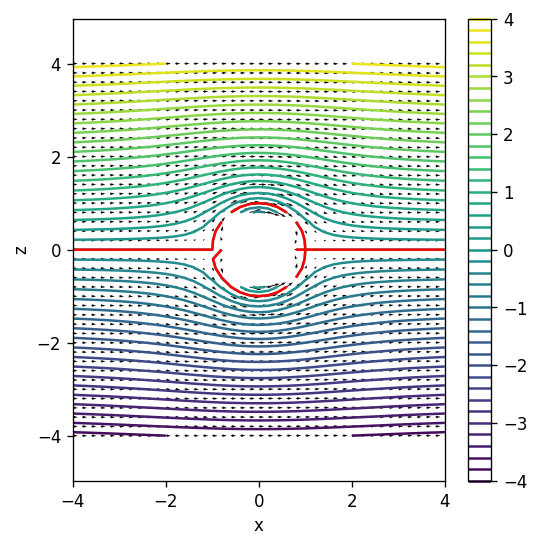

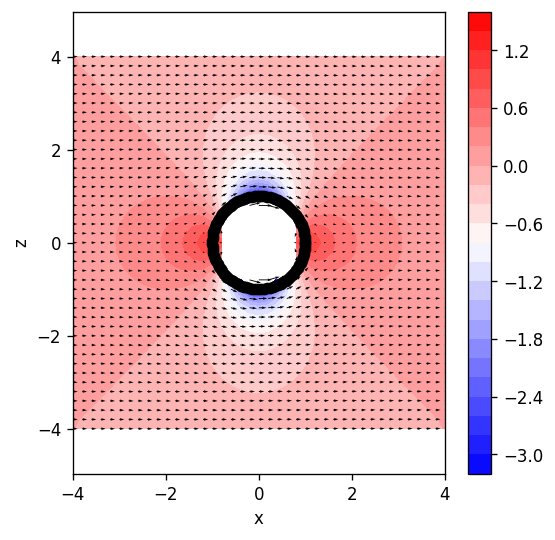

In [37]:
#This cell block will give us the flow past rankine full body.

Domain_x_min = -4
Domain_x_max = 4
Domain_z_min = -4
Domain_z_max = 4
dx = dz = 0.2

#We first create grid to compute the flow
[xa,za,x,z] = create_grid(Domain_x_min,Domain_x_max,Domain_z_min,Domain_z_max,dx,dz)

#Change the values of Uinf and Q to get different bodies.
Uinf = 1
alpha = 0
Kappa = 2*np.pi

R = np.sqrt(Kappa/(2*np.pi*Uinf))

psi = uniform_flow(Uinf,alpha) + doublet(kappa,0,0)

[u,w] = findvelocities(psi)

psi,u,w = mask_box(-R+2*dx,R-dx,-R+2*dz,R-dz,psi,u,w)

theta = np.linspace(0,2*np.pi,100)
xb = R*np.cos(theta)
zb = R*np.sin(theta)

Cp = findpressure(u,w,Uinf)

#We need to determine the circle streamline...

plt.figure(figsize=(5,5),dpi=120)
plt.contour(x,z,psi,50)
plt.colorbar()
plt.contour(x,z,psi,levels =[0],colors='red')
plt.quiver(x,z,u,w)
plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')
plt.show()

plt.figure(figsize=(5,5),dpi=120)
plt.contourf(x,z,Cp,np.arange(-3.2,1.6,0.2),cmap='bwr')
plt.colorbar()
plt.quiver(x,z,u,w)
plt.xlabel('x')
plt.ylabel('z')
plt.plot(xb,zb,'ko')
plt.axis('equal')
plt.show()

### Example 3 - Rankine full body flow

The second example for superposition is a Rankine full body.  Here, $\psi_1$ is a uniform flow, $\psi_2$ is a source and $\psi_3$ is a sink. This gives you a rankine full body! You can change the strength of source/sink relative to uniform flow to generate the size of the body.

### $\psi_{rankine full body} = \psi_{uniform flow} + \psi_{source} + \psi_{sink}$

It is important to remember to use the formulae either all in cartesian coordinates or all in cylindrical coordinates. Do not mix and match!


(-4.0, 4.0)

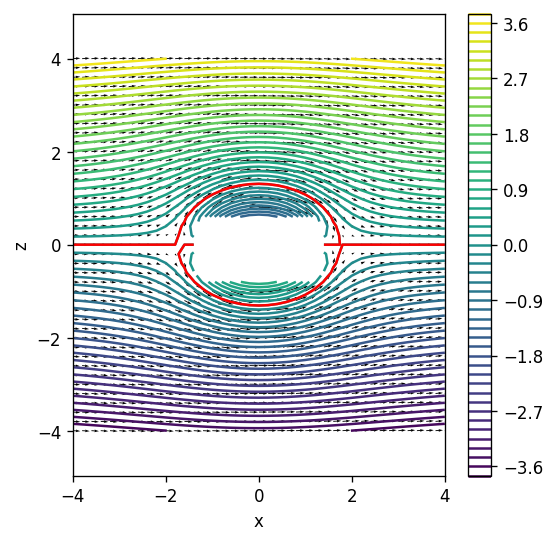

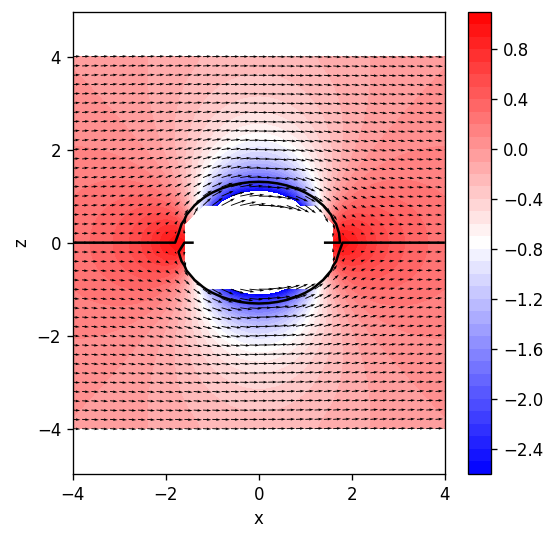

In [48]:
#This cell block will give us the flow past rankine full body.

#This is a dummy run to just show uniform flow
Domain_x_min = -4
Domain_x_max = 4
Domain_z_min = -4
Domain_z_max = 4
dx = dz = 0.2

#We first create grid to compute the flow
[xa,za,x,z] = create_grid(Domain_x_min,Domain_x_max,Domain_z_min,Domain_z_max,dx,dz)

#Change the values of Uinf and Q to get different bodies.
Uinf = 1
alpha = 0
Q = 2*np.pi
b = 1

psi = uniform_flow(Uinf,alpha)+ source(Q,-b,0) + source(-Q,b,0)

#psi,u,w = mask_box(-b-dx,b+2*dx,-3*dz,3*dz,psi,u,w)

[u,w] = findvelocities(psi)

Cp = findpressure(u,w,Uinf)

#We are computing the body here based on theory...

plt.figure(figsize=(5,5),dpi=120)       # make the plot
plt.contour(x,z,psi,50)      # streamlines
plt.colorbar()
plt.quiver(x,z,u,w,scale=50)
plt.contour(x,z,psi,levels = [0],colors='r')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim([-4, 4])
plt.ylim([-4, 4])


plt.figure(figsize=(5,5),dpi=120)
plt.contourf(x,z,Cp,np.arange(-2.6,1.2,0.1),cmap='bwr')
plt.colorbar()
plt.contour(x,z,psi,levels = [0],colors='black')
plt.quiver(x,z,u,w,scale=50)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim([-4, 4])
plt.ylim([-4, 4])

Now, we want to compute the parameters that govern the shape of the oval. These are the major and minor axes.
Once you know the parameters $Q$, $U_\infty$ and $b$, we can calculate $x_{end}$ and $z_{top}$ based on them. From the lecture slides, we know:

\begin{equation}
x_{end} = \pm\sqrt{b^2 + \frac{Qb}{\pi U_\infty}}
\end{equation}

However, $z_{top}$ has to be computed numerically by solving,

\begin{equation}
\psi = U_\infty z_{top} + \frac{Q}{2\pi}tan^{-1}(z_{top}/b)- \frac{Q}{2\pi}tan^{-1}(-z_{top}/b) = 0
\end{equation}

This non-linear equation needs to be solved to find roots.

An alternate way of representing the above equation is in terms of the angle made by the line joining the source that is located at $-b$ with the the point $z_{top}$. This angle can be denoted as $\zeta =tan^{-1}(z_{top}/b)$. The angle made by the sink with $z_{top}$, i.e. $tan^{-1}(-z_{top}/b)$ is is in fact equal to $\pi - \zeta$ (by trignometry). Therefore, the above equation for the streamline can be written in terms of this $\zeta$ as follows:
\begin{equation}
\psi = U_\infty b~tan\zeta + \frac{Q}{2\pi}(2\zeta - \pi) = 0
\end{equation}

We need to solve for $\zeta$ and then, use the relationship for $\zeta$ to get $z_{top}$. Note that solve for $\zeta$ and then getting $z_{top}$ is equivalent to solving directly for $z_{top}$. However, this second formulation helps us appoximate the solution analytically.


We can find an approximate solution for long slender bodies where $tan\zeta = \zeta$ (i.e when $z_{top} << b$. In this scenario, the above equation simplifies:

\begin{equation}
\zeta = \frac{\pi}{2 + 2\pi b U_\infty/Q}
\end{equation}

Then, $z_{top}$ = btan($\zeta$) = b$\zeta$ (plug in for $\zeta$ from the above equation). This is the formula given in the lecture slides for long slender bodies.


Now, let us compare the shape of the object (i.e. its aspect ratio defined as $AR = x_{end}/z_{top}$) for the values given. We can also see if the long-slender approximation is close to the real answer...

We can use $fsolve$ to solve the equation numerically and determine the $z_{top}$.

In [47]:
#We define the function of the streamline that are solving for...
def rankine_oval(ztop):
    return Uinf*ztop + (0.5*Q/np.pi)*np.arctan2(ztop,b)-(0.5*Q/np.pi)*np.arctan2(ztop,-b)

ztop = fsolve(rankine_oval,0)[0] # solves for top part of the ellipse

#For long slender bodies:
ztop_ls = b*np.pi/(2 + 2*np.pi*b*Uinf/Q)

#This is xend from the formula in lecture slides
xend = np.sqrt(b**2 + Q*b/(np.pi*Uinf))

AR = xend/ztop
AR_ls = xend/ztop_ls

print("Xend for a any oval is given by: ",np.round(xend,3))
print("Ztop for a general oval: ",np.round(ztop,3))
print("Ztop for long slender oval: ",np.round(ztop_ls,3))
print("AR for a general oval: ",np.round(AR,3))
print("AR for a long slender oval: ",np.round(AR_ls,3))


Xend for a any oval is given by:  1.095
Ztop for a general oval:  0.263
Ztop for long slender oval:  0.262
AR for a general oval:  4.169
AR for a long slender oval:  4.184


t should be noted that any streamline can represent a solid surface. Therefore, we can compute a different shaped surface/body by picking a given value of $\psi$ and assigning that to the body. The coordinates $(x,y)$ for the body is determined by solving the eqiation of the streamline for $\psi = \psi_b$.

\begin{equation}
\psi_b = U_\infty z + \frac{Q}{2\pi}tan^{-1}\left(\frac{z}{x+b}\right)- \frac{Q}{2\pi}tan^{-1}\left(\frac{z}{x-b}\right)
\end{equation}

To find the body in question here, we set $\psi_b = 0$. We already know from theory that the dividing streamline is in fact $\psi = 0$. Therefore, we solve for various values of $z$ given a range of input values of $x$ such that $psi$ = 0. This will gives us the $(x,y)$ coordinates that satisfies the equation of the streamline. So, in the $fsolve$ below, the value of $\psi_b$ represents the value of the streamline that we are solving for.

Since, the solution is symmetric, we just mirror the value of upper surface to the lower surface. However, we can also just look at flow in one-half of the domain. In that, case, the problem becomes a flow over a hill or an aircraft hangar (similar to the tutorial question) of a given size.   

(-4.0, 4.0)

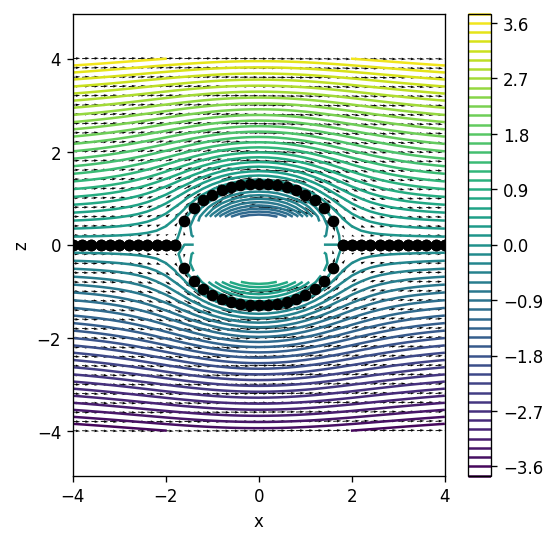

In [42]:
#Calculate the dividing streamline coordinates using fsolve
xb = xa #These are the x values that we want the solutions

#We define the function of the streamline that are solving for...
def rankine_oval(zbody):
    return Uinf*zbody + (0.5*Q/np.pi)*np.arctan2(zbody,xb+b)-(0.5*Q/np.pi)*np.arctan2(zbody,xb-b)

zt = fsolve(rankine_oval,xb) # solves for top part of the ellipse
zb = -zt; #We mirror it for the bottom part

plt.figure(figsize=(5,5),dpi=120)       # make the plot
plt.contour(x,z,psi,50)      # streamlines
plt.plot(xb,zt,'ko')
plt.plot(xb,zb,'ko')
plt.colorbar()
plt.quiver(x,z,u,w,scale=50)
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim([-4, 4])
plt.ylim([-4, 4])

## What if we want to get the pressure or velocity along the give streamline?

### This would typically be the case if we want to say get the pressure or velocity distribution along a body or along a wall that we want to model using potential flow.

### For example, let's try and find the velocity distribution and the pressure distribution along a streamline that passes through a given point. In this case, let's say we want the point to be (x,z) = (0,2).

### So, we first need to first find the value of the streamline that passes through this point.

### In the equation below, we plug in $x = 0$ and $z = 2$.

\begin{equation}
\psi_{str} = U_\infty z + \frac{Q}{2\pi}tan^{-1}\left(\frac{z}{x+b}\right)- \frac{Q}{2\pi}tan^{-1}\left(\frac{z}{x-b}\right)
\end{equation}

### We get $\psi_{str}$.

###  Now, the streamline passes through multiple (x,z) points. So, we can fix the value of x and then equation for streamfunction to get the value of z and that will give us the coodinates of all the points that the streamline passes through...

The value of streamfunction for streamline passing through (xc,zc):  1.073


(-4.0, 4.0)

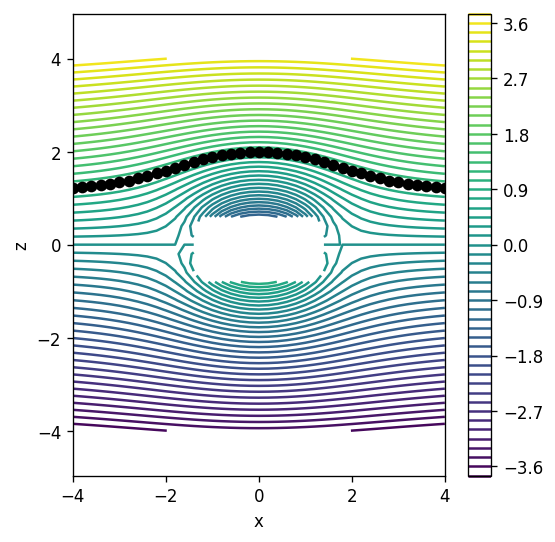

In [44]:
xc = 0
zc = 2

psi_str = Uinf*zc + (0.5*Q/np.pi)*np.arctan2(zc,xc+b)-(0.5*Q/np.pi)*np.arctan2(zc,xc-b)
print("The value of streamfunction for streamline passing through (xc,zc): ",np.round(psi_str,3))

x_str = xa #These are the x values that we want the solutions

#We define the function of the streamline that are solving for...
def rankine_oval(z_str):
    return Uinf*z_str + (0.5*Q/np.pi)*np.arctan2(z_str,x_str+b)-(0.5*Q/np.pi)*np.arctan2(z_str,x_str-b)-psi_str

z_str = fsolve(rankine_oval,np.ones(len(x_str)))

plt.figure(figsize=(5,5),dpi=120)       # make the plot
plt.contour(x,z,psi,50)      # streamlines
plt.plot(x_str,z_str,'ko')
plt.colorbar()
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim([-4, 4])
plt.ylim([-4, 4])



###Then use the formulae for $u$ and $w$ to compute the velocities along all those points.

\begin{equation}
u = U_\infty + \frac{Q}{2\pi}\left(\frac{x+b}{(x+b)^2 + z^2}- \frac{x-b}{(x-b)^2 + z^2}\right)
\end{equation}

\begin{equation}
w = \frac{Q}{2\pi}\left(\frac{z}{(x+b)^2 + z^2}- \frac{z}{(x-b)^2 + z^2}\right)
\end{equation}

### Note that in the above formula, we need to use $x = x_{str}$ and $z = z_{str}$ to get the velocities along a given streamline.


### Then we compute the pressure using the velocities.



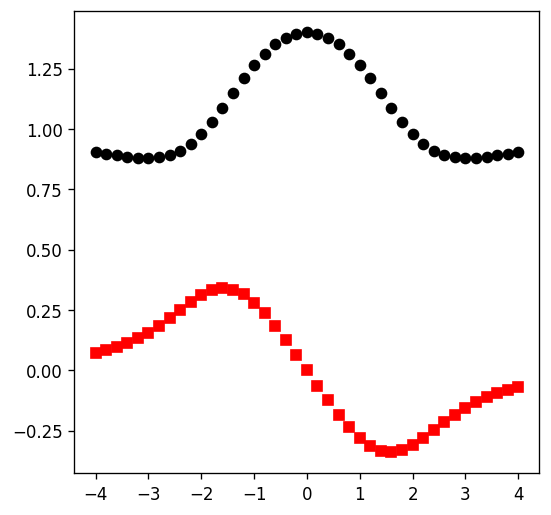

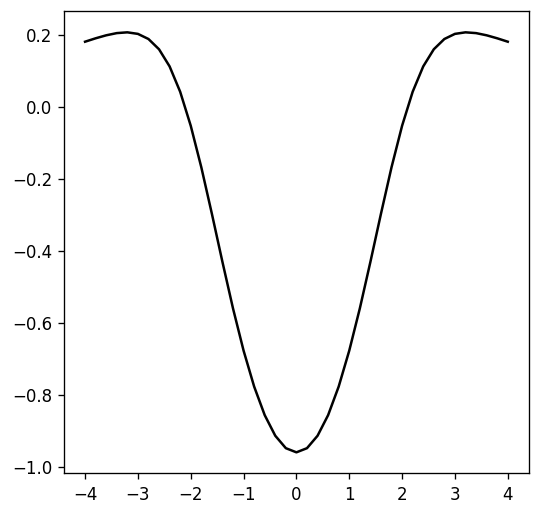

In [45]:
u_str = Uinf + (Q/(2*np.pi))*((x_str+b)/((x_str+b)**2 + z_str**2) - (x_str-b)/((x_str-b)**2 + z_str**2))
w_str = (Q/(2*np.pi))*((z_str)/((x_str+b)**2 + z_str**2) - (z_str)/((x_str-b)**2 + z_str**2))
Cp_str = 1 - (u_str**2+w_str**2)/Uinf**2

plt.figure(figsize=(5,5),dpi=120)       # make the plot
plt.plot(x_str,u_str,'ko')  #plot u velocity
plt.plot(x_str,w_str,'rs') # Plot w velocity

plt.figure(figsize=(5,5),dpi=120)       # make the plot
plt.plot(x_str,Cp_str,'k-') # Plot w velocity

## Example 4 - Lifting flow over circle (Cylinder in 2D)

We now superimpose a uniform flow with a doublet at the origin and we add a vortex to it. This gives a lifting flow over a circle.

### $\psi = U_\infty rsin\theta -\frac{\kappa}{2\pi}\frac{sin\theta}{r} + \frac{\Gamma}{2\pi} ln(r)$

It would be very helpful if the radius of the circle does not change when we change the strength of the vortex. Moreover, it would ideal if the streamline that captures the circle does not change if we change the vortex.

This can be easily achieved by just adding a constant to the above equation and find the value of that constant for $\psi = 0$. Note that when the vortex strength is zero, the streamline that captures the body is $\psi = 0$. This exercise will ensure that the streamline that captures the body remains the same!


You will also get $\epsilon = -\frac{\Gamma}{2\pi} ln R$ where $R = \sqrt{\kappa/2\pi U_\infty}$


So, the streamfunction becomes: $\psi = U_\infty rsin\theta (1 - R^2/r^2) + \frac{\Gamma}{2\pi} ln(r/R)$



If you plug in these values of $r$ and $\theta$ in to the equation for streamfunction, then, we get the value of streamfunction (or streamline) that represents the body as $\psi = 0$. So, we just need to identify the streamline corresponding to $\psi = 0$ to find the body.

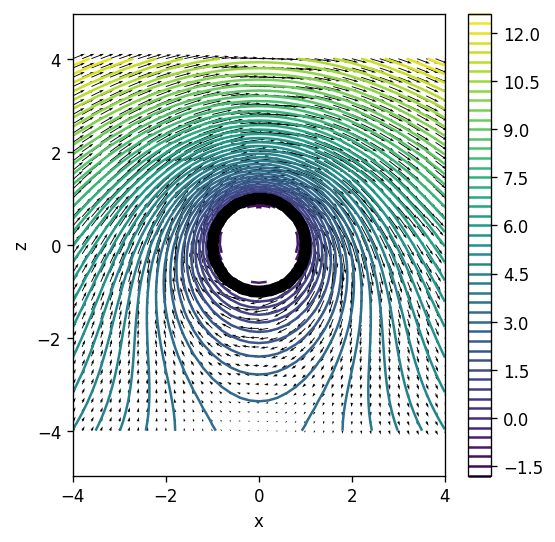

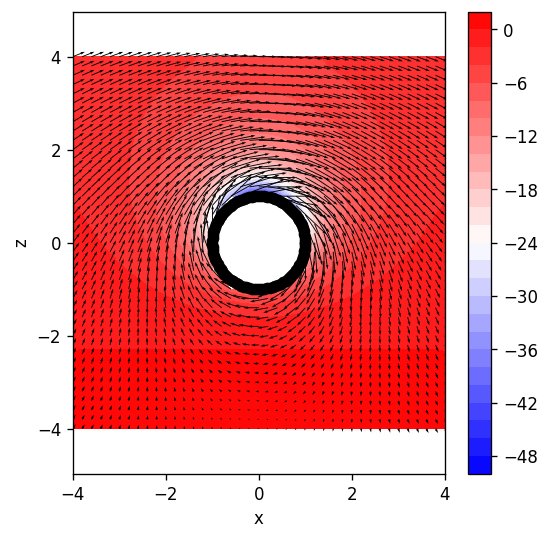

In [26]:
#This code block is to demonstrate a lifting flow past a circle

Domain_x_min = -4
Domain_x_max = 4
Domain_z_min = -4
Domain_z_max = 4
dx = dz = 0.2

#We first create grid to compute the flow
[xa,za,x,z] = create_grid(Domain_x_min,Domain_x_max,Domain_z_min,Domain_z_max,dx,dz)

#Change the values of Uinf, Kappa to change the size of the circle
Uinf = 1
Kappa = 2*np.pi
R = np.sqrt(Kappa/(2*np.pi*Uinf))
#Change the value of Gamma to change the circulation and hence lift
Gamma = 10*np.pi*R*Uinf

#Note that Gamma = 4*np.pi*R*Uinf is a critical value for the circulation where the stagnation points meet!

psi =  uniform_flow(Uinf,0) + doublet(Kappa,0,0) + vortex(Gamma,0,0)

psi,u,w = mask_box(-R+2*dx,R-dx,-R+2*dz,R-dz,psi,u,w)

[u,w] = findvelocities(psi)
Cp = findpressure(u,w,Uinf)

#We need to determine the circle streamline...
theta = np.linspace(0,2*np.pi,100)
xb = R*np.cos(theta)
zb = R*np.sin(theta)

plt.figure(figsize=(5,5),dpi=120)
plt.contour(x,z,psi,50)
plt.colorbar()
plt.quiver(x,z,u,w,scale=50)
plt.plot(xb,zb,'ko')
plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')
plt.show()

plt.figure(figsize=(5,5),dpi=120)
plt.contourf(x,z,Cp,30,cmap='bwr')
plt.colorbar()
plt.quiver(x,z,u,w,scale=50)
plt.plot(xb,zb,'ko')
plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')
plt.show()

## Method of Images

Method of Images is about enforcing a specific streamline to be a ground plane. This invovles making sure that there is "no-normal" at that plane. This is tpyically done by adding an "image" flow element that opposes the flow at a given plane. Sometimes this "image" flow element has an opposite sign to ensure the "no-normal" flow condition and at other times it could have the same sign. This changes depending on the situation. Typically, sources/sinks do not have to change sign but Doublets and vortices will have to change signs.


Once you have placed the right flow elements in appropriate places, then, you can find the streamfunction corresponding to the surface based on where the normal flow is zero. This streamline will only have tangential velocity along that plane. If you know the location and compute the tangential velocity, you can also get the pressure distribution along the plane.

### Example (5 & 6)

In this example, we have a vortex near the ground. This can be a lifting body near the ground (such a a quadrotor or race-car wing).

This same superposition also gives flow over a vertical ellipse (This is not method of images, but, a way to generate vertically oriented elliptical shapes).

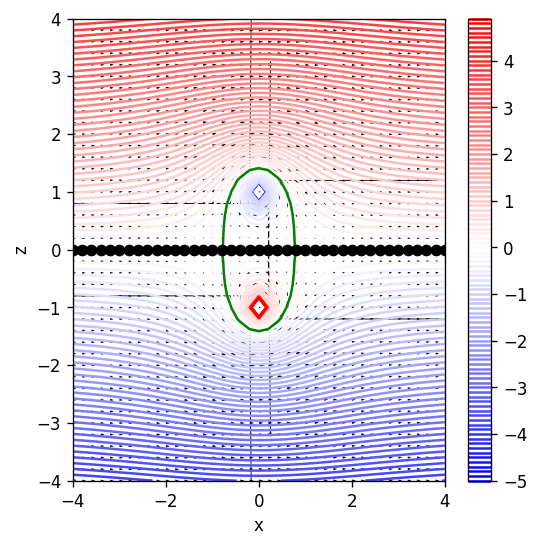

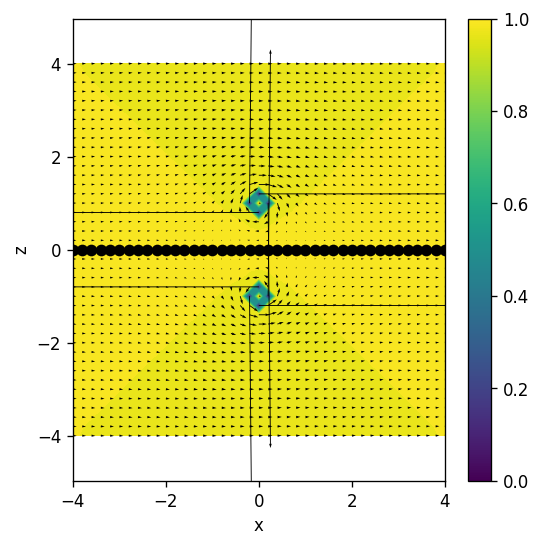

In [27]:
#This code block is to demonstrate method of image where we can use it solve either quadrotor near ground or flow over a vertical ellipse.

Domain_x_min = -4
Domain_x_max = 4
Domain_z_min = -4
Domain_z_max = 4
dx = dz = 0.2

#We first create grid to compute the flow
[xa,za,x,z] = create_grid(Domain_x_min,Domain_x_max,Domain_z_min,Domain_z_max,dx,dz)

#Change the value of Uinf, Gamma and a to get different flow patterns
Uinf = 1
alpha = 0
Gamma = 5
a = 1

psi = uniform_flow(Uinf,alpha) + vortex(Gamma,0,a) + vortex(-Gamma,0,-a)

[u,w] = findvelocities(psi)
Cp = findpressure(u,w,Uinf)

plt.figure(figsize=(5,5),dpi=120)
plt.contour(x,z,psi,np.arange(-5,5,0.1),cmap='bwr')
plt.colorbar()
plt.contour(x,z,psi,levels = [0],colors='green')
plt.plot(xa,np.zeros(len(xa)),'ko')

plt.quiver(x,z,u,w)
plt.xlabel('x')
plt.ylabel('z')
plt.show()

plt.figure(figsize=(5,5),dpi=120)
plt.contourf(x,z,Cp,50)
plt.plot(xa,np.zeros(len(xa)),'ko')
plt.quiver(x,z,u,w)
plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')
plt.colorbar()
plt.show()

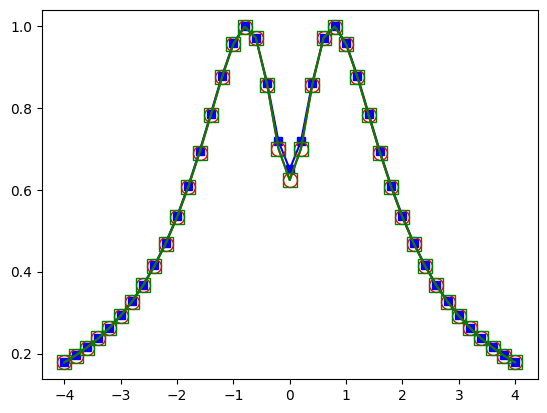

In [28]:
#Now let's figure out the pressure at the ground plane...
#Lets first plot the analytical solution as found in the lecture slides.
pp = -((Gamma*a)/(np.pi*Uinf*(xa**2+a**2)))**2 + 2*Gamma*a/(np.pi*Uinf*(xa**2+a**2))

plt.plot(xa,pp,'bs-')

#Next, we will find where z = 0 and plot the Cp along that location
#We know that the ground plane is at z = 0 across all x
#Let's find the index corresponding to z = 0 or close to it
wall_index = find_index(za,0)

#Note that "z" indices are the rows and "x" indices are the columns
# with Cp[wall_index,:], we are plotting the Cp at all values of x for z = 0
plt.plot(xa,Cp[wall_index,:],color='r', marker='o',mfc='none', markersize=10)

#This is an alternate way to find the pressure at the wall
#Here we interpolate the pressure using RectBivariateSpline interpolation...
Cpl_int = interpolate_values(xa,za,Cp,xa,0)

plt.plot(xa,Cpl_int,color='g',marker='s',mfc='none', markersize=10)

In the above figure, we have compared three different methods of getting the pressure. First, we plot find the index corresponding to a location and plot the pressure coefficient at that index (this is using the $np.where$ method).
Second, we plot the theoretical value as derived in the lecture slides.
You can see that both methods give us a very close answer. Third, we also compare an interpolation method using $RectBivariateSpline$. All three methods seems to give similar answers.  

However, I caution here that this is for this grid and resolution. If you changed the grid and resolution, this agreement will change. Specifically, the interpolation method might not agree with the other two methods.Go ahead and try with changing the grid and resolution and see what happens!

Typically, you should only use the former 2 methods as much as possible. It is best to get an analytical answer and compare to the finding the index method.